In [4]:
from PIL import Image

## 1. 예측 모델에 대한 개발 설명 

모델을 개발한 과정/방법에 대한 설명을 아래와 유사한 형태로 기술해 주세요.

### A. 분석 배경 및 과정

- 고객의 보유기간 예측 모델은 train_data의 hist_d와 hold_d 사이의 차이값이 146이하인 관계성이 중요하다고 판단된다.
- 따라서 train_data의 hist_d 값을 결정하는 것을 주요 분석 포인트로 잡았다.

### B. 추가 적으로 생성한 변수(feature)에 대한 설명

#### 'sum' 변수(Feature)
- 우선, 종목정보, 고객 및 주거래계좌 정보의 feature데이터에 따라 각 고객의 feature별 값에 따른 보유 기간에 차이가 발생할 것 이라고 가정한다.
- 따라서, feature별 보유기간의 평균값을 데이터 별로 'sum'에 저장해준다.
- 이를 통해 각 데이터에서 feature 별 특징을 보유기간의 길이로 반영해 준다.
- test_data에서는 이 보유기간을 hist_d로 생성해주었고, train_data에서는 이 보유기간을 hold_d로 생성해 주었다.

#### 'diff' 변수(Feature)
- 종목정보의 iem_krl_nm feature는 모든 종목에 대한 종류를 의미하는 feature이므로 고객 데이터 별로 다양한 값을 가진다.  
- 따라서, 고객 데이터 별로 iem_krl_nm feature의 특징을 보유기간의 길이를 통해 반영해주면 데이터 별로 구분 짓는 데 이점이 있을 것이라 판단하여 추가적으로 'diff' feature을 생성하였다.
- test_data에서는 이 보유기간을 hist_d로 생성해주었고, train_data에서는 이 보유기간을 hold_d로 생성해 주었다.

#### 'kos_idx' 변수(Feature)
- 'kos_idx' 변수는 개인이 주식 보유일이 보유하고있는 주식이 속한 시장의 지수와 관련이 있다고 생각하여 추가하였다.<br>
- train 데이터에서 매수, 매도일 사이 변화한 시장 지수값의 분포를 확인해보니 대부분이 0에 가까운 정규분포를 이루고 있었다.
- test 데이터의 경우는 정규분포를 이루지 않고 평균값이 중앙값보다 낮게 나타났는데, 이는 test 데이터에서 hold_d 값이 아닌 hist_d 값을 사용하여 나타난 결과라고 생각하였다.

- 코스피200 지수를 예로 들면, 2016~2020년 동안 약 155 증가했으며, 이는 하루 평균 약 0.126정도 증가한 것이다. 실제로 2021년에는 코스피지수가 계속 상승하였다.
- 따라서 test에 hold_d를 기준으로 하면 변화한 시장 지수 값이 평균과 중앙값 최빈값이 일치하는 정규분포 형태를 띌 것이라고 가정였다.<br>
- 이렇게 되면 현재 평균값이 중앙값보다 작으므로 차이를 구할 수 있고(물론 hold_d의 값이 hist_d보다 크다면 평균값과 중앙값이 모두 증가하겠지만, 평균값의 변화가 더 클 것이므로 중앙값을 기준으로 한다), 이 차이를 하루 평균 증가한 시장 지수 값으로 나누어 hist_d 만큼보유 후 '2021년에 보유일'을 통계적으로 구할 수 있다.

- 이렇게 구한 값을 hist_d와 더하여 hold_D에 근접하는 값을 'kos_idx' 변수로 만들어 사용하였였다.

#### 'krx_idx' 변수(Feature)
- 'krx_idx'를 생성한 방식은 'kos_idx'와 동일하나 기준이 종목이 속한 시장이 아닌 업종을 기준으로 하였다.

### C. train_data의 hist_d feature 생성

- 기존의 baseline코드에서는 hist_d에 hold_d*0.6을 넣어주었다.
- 하지만 해당 방식을 적용할 경우 hold_d - hist_d <= 146인 상황을 온전히 반영하지 못한다고 판단하였다.
- 따라서 hold_d의 크기 별로 구간을 나누어 hist_d의 값을 결정하는 방식을 고안하였다.
- 또한, 종목정보와 고객 및 주거래계좌 정보의 feature데이터에 따른 보유기간의 차이를 적용한 feature 'sum'을 이용하여 고객의 hist_d feature가 종목정보와 고객 및 주거래계좌 정보 feature들의 값에 따른 특성을 보유기간에 반영하도록 해주었다. 

- 구간은 hold_d의 값에 따라 30 ~ 60, 60 ~ 100, 100 ~ 147, 그리고 147 ~ 로 총 4개로 나누었다.
- 또한, 위에서 생성해준 sum feature을 적용하였다.
- 적용 방법은 다음과 같다.
    1. 구간 별 sum의 max값을 구한다.
    2. sum/sum_max값이 1보다 작고, (sum*hold_d)/ sum_max <= hold_d이므로 (sum * hold_d)/ sum_max = hold_d - hist_d로 가정한다.
    3. 2,의 성립을 위해서는 sum이 클수록 hold_d - hist_d가 크다는 가정이 필요하다.
    4. 2.에서 생성한 hold_d - hist_d를 hold_d에 빼주어 각 구간 별 hist_d에 넣어준다.
    5. 이때, 147~ 구간은 sum_max값이 다른 구간의 값보다 비교적 크기 때문에 sum/sum_max값이 너무 작아지는 문제가 발생할 수 있어 sum_max값 보다 작은 값을 사용하여 이러한 문제를 막아준다.

### D. 최적 모델 선정

- 최종 모델은 기존 baseline 모델인 lgbm을 사용하였다.
- xgboost 과 tabnet을 적용하여 보았지만 성능 개선이 뚜렷하게 보이지 않아 기존 모델인 lgbm을 채택하였다.
- kfold의 경우 split개수 = 10으로 설정해 주었다.
- lgbm의 파라미터의 경우 아래와 같이 설정해 주었다.
    - max_depth = 5
    - n_estimators = 3500
    - learning_rate = 0.01
    - num_leaves = 31

### E. 모델링 진행 및 중요한 가정들

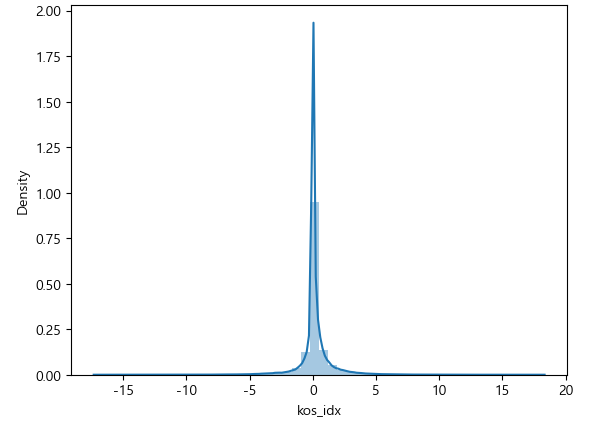

In [7]:
Image.open("train_data_kos.png")

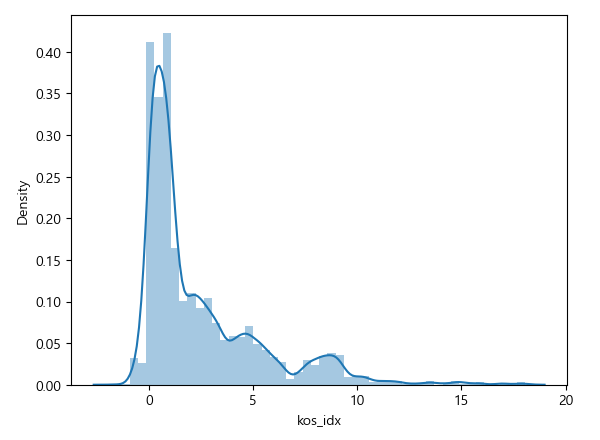

In [8]:
Image.open("test_data_kos.png")

- 거래 내역에서 매수일과 매도일 사이의 주식 지수값은 정규분포를 이룬다는 가정이 있다.
- 이는 train 데이터에서 각 종목이 속한 시장 지수변화값을 기준으로 분포를 확인한 결과 정규분포임을 위의 히스토그램에서 확인하였다.
- test 데이터는 평균이 최소값에 가깝게 분포가 되어있었고 정규분포를 이루지 않았는데, 이 과정에서 test 데이터도 'hist_d' + '21년 보유일'로 시장 지수 변화값을 분포로 보면 정규분포를 이룰 것이라 가정하였다.


- 하루평균시장지수변화값의 경우 양의값을 갖는다고 가정하였고, 이는 2016~2020년의 시장지수 데이터를 통해 양의 값임을 확인하였다.


- 각 데이터들의 시장지수변화값, 모든 데이터의 시장지수중앙값, 하루평균시장지수변화값을 이용하여 'kos_idx' 를 구하는 과정에서 구한 '2021년 보유일'은 0~146의 값을 가져야만 한다.<br>
- 따라서 지수를 이용한 '2021년 보유일'이 0보다 작을경우 0, 146보다 클 경우 146으로 값을 수정하였다.

### F. 모델링에 대한 추가적인 특이사항

- 최종 예측 결과 생성 시
    - 아래와 같이 일괄처리 해줌으로서 hold_d - hist_d < 146인 조건을 충족 시켜줌
    - hold_d - hist_d < 1 이면 hold_d = hist_d + 9
    - hold_d - hist_d > 146 이면 hold_d = hist_d + 138

## 2. 외부 데이터에 대한 설명

아래 정보를 포함하여 자유롭게 기술해 주세요

- 데이터 종류/분류  
- 데이터 원천/웹사이트  
- 수집/적재 방법  
- 전처리 방법  
- 활용 방안  
- 활용한 이유  
- 지속성에 대한 설명  

- 데이터 종류/분류
    - 외부 데이터의 종류는 종목업종 데이터이다.
    - 건설, 금융, 기계, 통신, 서비스, 운송, 유통, 의료, 전기, 제조, 철강, 화학, IT, 기타 데이터에 맞도록 KRX데이터를 가져왔다.
    - 해당 종목 업종 관련 KRX데이터가 없을 경우 KOSPI와 KOSDAQ데이터를 가져왔다.


- 외부 데이터 공유 드라이브
    - https://drive.google.com/drive/folders/1T3mcWrV4rK8dDyBQk7LnQS6k_YFSCB2r?usp=sharing
    
    - 위의 공유 드라이브에서 데이터 다운로드는 가능하며, 추가적으로 원천 데이터 다운로드 방법은 아래 참고
    
- 외부 데이터 원천/웹사이트 
    1. https://kr.investing.com/indices/south-korea-indices?&primarySectors=on&otherIndices=on
    2. http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201


- 수집 방법 : 위의 외부 데이터 공유 드라이브에서 다운로드 가능, 직접 다운로드 시에는 아래 방법 사용
    1. https://kr.investing.com/indices/south-korea-indices?&primarySectors=on&otherIndices=on
        - 링크 접속
        - 종류 선택 : 
        KOSDAQ Machinery, KRX Transportation, KRX Steel, KRX Media & Telecom, KRX Health Care, KRX Energy & Chemical, KRX Constructions, KRX Semiconductor, KRX Bank, KOSDAQ Entertainment & Culture, KOSDAQ Manufacturing, KOSPI 200 IT
        - 윗쪽 부분에 있는 '과거 데이터' 선택
        - '데이터 다운로드' 버튼 옆의 날짜 선택 버튼 클릭
        - 날짜 지정 시작일자 : 2016/01/01, 종료 일자 : 2020/12/31
        - '신청합니다' 버튼 클릭
        - '데이터 다운로드' 버튼 클릭
        - 위의 과정을 2번 항목의 데이터들에 대해 반복 수집
        
    2. http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201
        - 링크 접속
        - 왼쪽 메뉴바에서 '지수' -> '주가지수' -> '개별지수 시세추이' 선택
        - 지수명에서 종류 검색 : 
        코스피200, 코스닥150, 코스피200제외 코스피지수
        - 아래 조회기간 날짜 지정 : 2016/01/04 ~ 2020/12/30
        - '조회' 클릭
        - '조화' 버튼 아래 파란색 '다운로드' 클릭 후 csv 파일 다운로드<br><br>
        
        - <span style="color:red">직접 다운로드 시,  csv 파일의 경우 다운받은 날짜에 따라 이름이 바뀌어 파일 경로의 파일명도 변경해줘야 함</span>

- 전처리 방법 
    - 외부 데이터 str type을 int type으로 변경
    - 외부 데이터로 부터 생성된 데이터 프레임에서 필요없는 컬럼 삭제 및 컬럼 이름 변경

    
- 활용 방안    
    - 외부 데이터(시장지수)로 새로운 변수 생성(자세한 설명은 1.A'에 kos_idx 참고)
    - train 데이터에서는 정확한 매수일과 매도일을 알 수 있으므로, 날짜를 통한 외부 데이터를 이용해 모델링 진행중 변수 생성을 위해 설정한 가정을 체크해볼 수 있음
    - test 데이터에서는 보유일의 일부분을 알 수 있으므로 앞서 체크한 가정을 통해 도출해낸 새로운 변수를 통해 보유일의 나머지 부분을 통계적으로 구할 수 있음
    
    
- 활용한 이유
    - 품목 별 데이터를 사용할 경우 품목 별 지수의 특징을 데이터에 적용할 수 있기 때문에 사용
    
    - 주식 수익에 있어서 경험 및 통계적으로 대부분의 사람들은 수익 및 손해가 적은 편이고 적은 사람들많이 큰 변동폭을 가지고 이는 그래프로 그려보면 정규분포를 따를 것이라 생각함<br>
    - 이를 이용하여 매수, 매도일 사이의 시장 지수값 변화를 이용하여 미래의 보유일을 예측할 수 있다고 생각함.
 
- 지속성에 대한 설명
    - 매수 일로부터 현재 시점까지의 외부 데이터를 사용하면 꾸준한 적용이 가능하다고 생각

** 외부데이터는 2021년 데이터를 사용하지 않도록 유의합니다: Data Leakage에 해당